### WARNING:
#### This notebook could be very slow without a GPU.
##### Note: I've used Nvidia GeForce 1050 ti 4gb.

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
import tensorflow as tf

assert tf.__version__ >= "2.8.0"

In [3]:
import pandas as pd
import numpy as np

np.random.seed(42)

In [4]:
from pathlib import Path

IMAGES_PATH = Path()
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

2022-10-25 14:17:59.856855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 14:17:59.894916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-25 14:17:59.895141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [7]:
try:
    df = pd.read_csv('/home/asjad/Desktop/mynewtable.csv',
                         parse_dates=["tx_datetime"])
    df = df.set_index("tx_datetime")
    print("Dataset has been loaded")
    
except:
    print('Unable to load dataset')

Dataset has been loaded


In [8]:
df

,customer_id,tx_amount,terminal_id,tx_type
tx_datetime,,,,
2018-04-01 04:31:00+05:00,28,84.230003,17,0
2018-04-01 17:23:31+05:00,296,120.649994,15,3
2018-04-01 05:39:28+05:00,188,53.290001,16,0
2018-04-01 06:57:01+05:00,188,29.950001,16,0
2018-04-01 07:24:08+05:00,188,10.310000,16,0
...,...,...,...,...
2018-07-29 13:26:25+05:00,467,78.720001,17,2
2018-07-30 08:52:24+05:00,467,47.520000,16,0
2018-07-30 16:53:06+05:00,467,125.110001,18,3


In [9]:
df['tx_type'].value_counts()

2    3287
0     886
3     366
1     206
Name: tx_type, dtype: int64

#### Assuming 4 different transactions type:

#### 0 = fuel,

#### 1 = pharm,

#### 2 = food, 

#### 3 = superstore.

In [10]:
df.shape

(4745, 4)

In [11]:
df.describe()

,customer_id,tx_amount,terminal_id,tx_type
count,4745.000000,4745.000000,4745.000000,4745.000000
mean,263.093151,47.428182,10.782086,1.660274
std,147.278627,43.331870,5.451547,0.867286
min,15.000000,0.010000,1.000000,0.000000
25%,132.000000,18.240000,5.000000,2.000000
50%,235.000000,39.220001,12.000000,2.000000
75%,405.000000,63.709999,16.000000,2.000000
max,498.000000,597.400024,18.000000,3.000000


101 is the lowest spending and 9992 is the highest spending


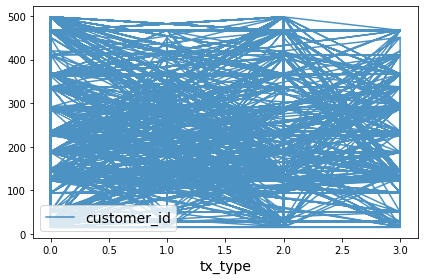

In [13]:
import matplotlib.pyplot as plt

df.plot(kind="line", x="tx_type", y="customer_id", alpha=0.8)
save_fig("transaction_type against cust_id")

In [14]:
from datetime import datetime
print("lowest transaction_amount date_time:", datetime.fromtimestamp(70741065))
print("highest transaction_amount date_time:", datetime.fromtimestamp(1030973928))

lowest transaction_amount date_time: 1972-03-29 23:17:45
highest transaction_amount date_time: 2002-09-02 19:38:48


let's see the trend from the begining to the last obs we have

In [ ]:
df['96256':'1661580095'].plot(grid=True, marker=',', figsize=(8, 3.5), alpha=0.8)
save_fig('transaction_amount, cust_id with time')
plt.show()

let's check if after 1972-03-29 23:17:45 any low amount transaction occured till the end 2022-08-27 11:01:35


In [ ]:
df['70741065':'1661580095'].plot(grid=True, marker=',', figsize=(8, 3.5),
                                  alpha=0.8)
plt.show()

#### There's no such events that shows the transaction amount decreased below 101, after 1972-03-29 23:17:45 till 2022-08-27 11:01:35


In [ ]:
#print(datetime.fromtimestamp(1260738756))
#print(datetime.fromtimestamp(1048305858))
print(datetime.fromtimestamp(1661580095))

#### Hence: The minimum transaction amount is 101, held on 1972-03-29 23:17:45 by cust_id: 9042

#### And the maximum transaction amount is 4998, held on 2002-09-02 19:38:48. by cust_id: 8646

In [ ]:
# Checking the daytype on which minimum transactions occured

list(df.loc["70741065"]["day_type"])

In [ ]:
# Checking the daytype on which maximum transactions occured

list(df.loc["1661580095"]["day_type"])

####  'w' describe the weekday(mon-fri), day_type, therefore we can say that both the lowest and the highest transactions occured on weekend!!

In [15]:
df_mulvar = df[["customer_id", "tx_amount"]] # using both as inputs
df_mulvar

,customer_id,tx_amount
tx_datetime,,
2018-04-01 04:31:00+05:00,28,84.230003
2018-04-01 17:23:31+05:00,296,120.649994
2018-04-01 05:39:28+05:00,188,53.290001
2018-04-01 06:57:01+05:00,188,29.950001
2018-04-01 07:24:08+05:00,188,10.310000
...,...,...
2018-07-29 13:26:25+05:00,467,78.720001
2018-07-30 08:52:24+05:00,467,47.520000
2018-07-30 16:53:06+05:00,467,125.110001


In [ ]:
df_mulvar["day_type"] = df["day_type"].shift(-1)
df_mulvar["transaction_type"] = df["transaction_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)
df_mulvar


In [ ]:
1096 + 914 + 151

In [ ]:
df_mulvar.shape

In [ ]:
# 60% of the 2000
0.6 * 2000

In [ ]:
# 30% of the 2000
0.3 * 2000

In [ ]:
# 10% of the 2000
0.1 * 2000

In [ ]:
# split the dataset in 70%, 30%, 30% to train, valid, and test set repectively

mulvar_train = df_mulvar["96256":"1007875248"]
mulvar_valid = df_mulvar["1010586936":"1507568833"]
mulvar_test = df_mulvar["1507726526":]

print("mulvar_train.shape:", mulvar_train.shape)
print("mulvar_valid.shape:", mulvar_valid.shape)
print("mulvar_test.shape:", mulvar_test.shape)

In [ ]:
mulvar_train

In [ ]:
tf.random.set_seed(42)
seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(), # use all 8 columns as input
    targets = mulvar_train['cust_id'][seq_length:], # forecast only the 'cust_id series'
    sequence_length = seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets = mulvar_valid['cust_id'][seq_length:],
    sequence_length = seq_length,
    batch_size=32
)

In [ ]:
train_mulvar_ds

In [ ]:
valid_mulvar_ds

In [ ]:
tf.random.set_seed(42)



In [ ]:
import joblib

In [ ]:
def fit_and_evaluate(train_set, valid_set, learning_rate, epochs):
    try:
        model = joblib.load("bj_model.pkl")
        print("Model has been loaded")
                    
    except:
        try:
            tf.random.set_seed(42)
            
            model = tf.keras.Sequential([
                tf.keras.layers.SimpleRNN(32, input_shape=[None, 8]),
                tf.keras.layers.Dense(1)
            ])
            
            early_stopping_cb = tf.keras.callbacks.EarlyStopping(
                monitor = "val_mae", patience=50,
                restore_best_weights=True)
            
            opt = tf.keras.optimizers.SGD(learning_rate=0.05,
                                      momentum=0.9)
            
            model.compile(loss=tf.keras.losses.Huber(),
                                 optimizer=opt,metrics=["mae"])
    
            history = model.fit(train_mulvar_ds,
                                       validation_data=valid_mulvar_ds,
                                       epochs=epochs,
                                       callbacks=[early_stopping_cb])

        except:
            model = None
            print("Model is None")
            
        try:
            if model != None:
                joblib.dump(model, "bj_model.pkl")
                print("Model has been saved to disk")
                
            else:
                print("Unable to save model to disk")
                
        except:
            print("Error in model training")
            
    return model

In [ ]:
model = fit_and_evaluate(train_mulvar_ds, valid_mulvar_ds,
                 learning_rate= 0.05, epochs=10)

In [ ]:
valid_loss, valid_mae = model.evaluate(valid_mulvar_ds)
print(valid_loss)
print(valid_mae)
           


In [ ]:
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_test.to_numpy(),
    targets = mulvar_test['cust_id'][seq_length:],
    sequence_length=seq_length,
)

In [ ]:
test_mulvar_ds

In [ ]:
forecast = model.predict(test_mulvar_ds)

In [ ]:
forecast